# Hockey Spatial Analysis: 空間統計による真の貢献度可視化プロジェクト

本ノートブックでは、MoneyPuck.com から取得した 2024 年シーズンの実ショットデータを用い、シュートの「場所の難易度」を考慮した上でゴテンダーの真の実力（GSAx）を推定します。
特に、データが限られた「小規模データ（500件）」環境において、ベイズ階層モデルがいかにして安定した意思決定を支援するかを、3層の戦略的フィルタリングを通じて実証します。

In [1]:
# 必要なライブラリ
import os
import requests
import zipfile
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
from sklearn.preprocessing import SplineTransformer

# 不要な出力の制御
import warnings

warnings.filterwarnings("ignore")

In [2]:
# プロジェクト共通のカラー定義（実際の運用では /src にモジュール化を推奨）
COLOR_PURPLE = "#9B5DE5"  # 事後分布・HDI
COLOR_YELLOW = "#F9C74F"  # ROPE領域
COLOR_GREEN = "#06D6A0"  # 改善判定
COLOR_RED = "#EF476F"  # 悪化判定
COLOR_GRAY = "#8D99AE"  # 等価判定・参照線

plt.rcdefaults()
palette_brand = [COLOR_PURPLE, COLOR_YELLOW, COLOR_GREEN, COLOR_RED, COLOR_GRAY]
sns.set_theme(style="whitegrid", palette=palette_brand)
plt.rcParams["axes.prop_cycle"] = cycler(color=palette_brand)

print("Brand Style Applied: The visual identity was applied.")

Brand Style Applied: The visual identity was applied.


分析に必要な統計・可視化ライブラリをロードし、レポートの品質を担保するためのデザイン設定（`Seaborn` / `Japanize-Matplotlib`）を行います。

> Tips:
>
> 分析結果のビジュアルを統一し、どのグラフを見ても「紫は実力、緑は成功」と直感的に理解できるようにしています。
>
>
> Color Cycle
> グラフを描画する際、色が指定されていない場合に自動的に適用される色の順番です。
> 最初は紫、次を黄色...と決めておくことで、毎回指定しなくても色が揃います。
>
>
> ビジネスレポートにおいて「色の意味」を固定することは、意思決定のスピードを劇的に高めます。
> 複数の Notebook を管理する実務現場では、これを共通モジュール化し、メンテナンス姓を高めることを推奨します。

## 1. データ準備（Preparation）
外部ソース（[Moneypuck.com](https://moneypuck.com/)）から ZIP形式の巨大なデータセットを自動取得し、解析可能な状態に展開します。


In [3]:
# データのダウンロード（MoneyPuck 2024 shots Data）
URL_DATA = "https://peter-tanner.com/moneypuck/downloads/shots_2024.zip"
DIR_EXTRACT = "data_raw"
NAME_ZIP = "shots_2024.zip"
NAME_CSV = "shots_2024.csv"
PATH_CSV = os.path.join(DIR_EXTRACT, NAME_CSV)

if os.path.exists(PATH_CSV):
    # すでに CSV が存在する場合はスキップ
    print(f"Data Preparation: Local CSV found at {PATH_CSV}. Skipping download.")

else:
    # ファイルがない場合: ダウンロードと展開を実行する
    print("Data Preparation: CSV not found. Starting automated setup...")

    # 保存先ディレクトリの作成
    if not os.path.exists(DIR_EXTRACT):
        os.makedirs(DIR_EXTRACT)
        print(f"Data Preparation: Created directory '{DIR_EXTRACT}")

    # ダウンロード
    print(f"Data Preparation: Downloading from {URL_DATA}...")
    try:
        response = requests.get(URL_DATA)
        with open(NAME_ZIP, "wb") as f:
            f.write(response.content)

        # ZIP の展開
        print(f"Data Preparation: Extracting {NAME_ZIP}...")
        with zipfile.ZipFile(NAME_ZIP, "r") as ref_zip:
            ref_zip.extractall(DIR_EXTRACT)

        # 元の ZIP ファイルの削除（クリーンアップ）
        if os.path.exists(NAME_ZIP):
            os.remove(NAME_ZIP)
            print(f"Data Preparation: Cleand up temporary ZIP file '{NAME_ZIP}'")

        # 展開ファイルの確認
        files = os.listdir(DIR_EXTRACT)
        print(f"Data Preparation: Extracted files: {files}")
    except Exception as e:
        print(f"Data Preparation Error: {e}")

Data Preparation: CSV not found. Starting automated setup...
Data Preparation: Downloading from https://peter-tanner.com/moneypuck/downloads/shots_2024.zip...
Data Preparation: Extracting shots_2024.zip...
Data Preparation: Cleand up temporary ZIP file 'shots_2024.zip'
Data Preparation: Extracted files: ['shots_2024.csv', 'goalie_final_investment_report.csv', 'data_goalie_rope_analysis.csv', 'final_roi_report_chart.png']


In [4]:
# データのプレビュー（ホワイトボックス化）
CSV_TARGET = os.path.join(DIR_EXTRACT, "shots_2024.csv")

# 先頭５行を確認
df_preview = pd.read_csv(CSV_TARGET, nrows=5)
print("Data Preparation: Preview of the data:")
df_preview.head()

Data Preparation: Preview of the data:


,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,...,xCordAdjusted,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,yCord,yCordAdjusted
0,0,52.0,57.0,57.0,-41.0,41.0,0.0,0,0,0,...,57,0.238455,0.012537,0.394229,0.301072,0.022807,0.030900,0.710867,-40,-40
1,1,33.0,71.0,71.0,-28.0,28.0,-6.0,0,0,0,...,71,0.198306,0.021962,0.404919,0.313773,0.023774,0.037266,0.759039,-28,-28
2,2,48.0,48.0,48.0,-24.0,24.0,-12.6,0,0,0,...,48,0.213829,0.028057,0.405311,0.294682,0.025849,0.032272,0.696901,-24,-24
3,3,58.0,-40.0,40.0,-31.0,31.0,0.0,0,0,0,...,41,0.209478,0.009832,0.449775,0.277671,0.019667,0.033577,0.610530,-31,31
4,4,56.0,-35.0,35.0,15.0,15.0,0.0,0,0,0,...,36,0.376712,0.028884,0.307725,0.205568,0.022266,0.058845,0.799576,15,-15


膨大なカラムを持つデータから、空間的な「期待ゴール率」と「ゴテンダー評価」に直結する最小限の変数のみを抽出してロードします。

In [5]:
# 利用する列を展開してロード（メモリ効率化）
COLS_USE = [
    "shotID",
    "goal",  # 1: Goal, 0: No Goal
    "xCordAdjusted",  # 調整済み x 座標
    "yCordAdjusted",  # 調整済み y 座標
    "goalieIdForShot",  # ゴテンダー ID
    "goalieNameForShot"  # 選手名
]

print("Data Preparation: Loading real dataset from CSV...")
df_raw = pd.read_csv(CSV_TARGET, usecols=COLS_USE)

print(f"Data Preparation: Data load finished. {len(df_raw):,} rows")
df_raw.head()

Data Preparation: Loading real dataset from CSV...
Data Preparation: Data load finished. 119,870 rows


,shotID,goal,goalieIdForShot,goalieNameForShot,xCordAdjusted,yCordAdjusted
0,0,0,8480045,Ukko-Pekka Luukkonen,57,-40
1,1,0,8480045,Ukko-Pekka Luukkonen,71,-28
2,2,0,8480045,Ukko-Pekka Luukkonen,48,-24
3,3,0,8474593,Jacob Markstrom,41,31
4,4,0,8474593,Jacob Markstrom,36,-15


投影（Projection / usecols）
- 巨大なデータセットから、特定の属性（列）のみの選択をしてメモリに読み込むようにします。
データ全てを覚えるのではなく、必要なカラムだけを抽出することで作業効率を劇的に上げるテクニックです。

## データ加工（Processing）
キーバーがいない状況でのゴールなど、能力評価においてノイズとなるデータを除外します。

In [6]:
# クレンジング:
df_clean = df_raw.dropna(subset=["goalieIdForShot"]).copy()  # ゴテンダー不在（Empty Net）データの厳密な除外
df_clean = df_clean[df_clean["goalieIdForShot"] > 0].copy()  # MoneyPuck データでは無人ゴール時に ID が 0 や欠損になるため、これを除外します。

print(f"Data Processing: {len(df_clean):,} rows left after cleaning.")

Data Processing: 118,900 rows left after cleaning.


データが少ない環境（新規事業や特定セグメントの分析）を再現し、不可実性下での判断プロセスを構築します。

In [7]:
# 小規模データ化（３桁台のサンプリング）
# 意思決定の難易度が高い「事例が少ない」状況を再現するため、あえて 500 件に絞ります
SIZE_SAMPLE = 500
df_small = df_clean.sample(n=SIZE_SAMPLE, random_state=42).reset_index(drop=True)

df_small

,shotID,goal,goalieIdForShot,goalieNameForShot,xCordAdjusted,yCordAdjusted
0,77213,0,8480947,Kevin Lankinen,57,-17
1,62564,1,8482487,Jakub Dobes,42,12
2,50703,0,8480382,Alexandar Georgiev,76,10
3,80853,1,8479406,Filip Gustavsson,72,14
4,65495,0,8481020,Justus Annunen,23,-39
...,...,...,...,...,...,...
495,43089,0,8475683,Sergei Bobrovsky,56,-12
496,50168,0,8481611,Pyotr Kochetkov,66,35
497,15962,0,8480280,Jeremy Swayman,62,16
498,68658,0,8475683,Sergei Bobrovsky,37,11


カテゴリ変数（ID）を確率モデルが扱える形式に変換し、結果の解釈をしやすくするための紐付けを行います。

In [8]:
# インデックス化
# 選手ID を 0 からの連番に変換し、ID から名前を引く辞書を作成します
codes_goalie, uniques_goalie = pd.factorize(df_small["goalieIdForShot"])
df_small["idx_goalie"] = codes_goalie
df_small["obs_shots"] = df_small["goal"].astype(int)

# ID から名前を引くためのマップ
id_to_name = df_small.set_index("idx_goalie")["goalieNameForShot"].to_dict()

print(f"Data Processing: unique count of Goalie {len(uniques_goalie):,}")
df_small[["goalieIdForShot", "idx_goalie", "obs_shots"]]

Data Processing: unique count of Goalie 79


,goalieIdForShot,idx_goalie,obs_shots
0,8480947,0,0
1,8482487,1,1
2,8480382,2,0
3,8479406,3,1
4,8481020,4,0
...,...,...,...
495,8475683,25,0
496,8481611,30,0
497,8480280,18,0
498,8475683,25,0


座標（$x$, $y$）とう数値を、モデルが「どのエリアが危険か」を滑らかに学習できる高度な特徴量に変換します。

In [9]:
# 特徴量生成（空間基底関数の適用）
# 座標データから滑らかな空間曲面（スプライン基底）を生成します
spline = SplineTransformer(n_knots=5, degree=3, include_bias=False)
basis_spatial = spline.fit_transform(df_small[["xCordAdjusted", "yCordAdjusted"]])

print(f"Data Processing: 特徴量行列の計上 {basis_spatial.shape}")

Data Processing: 特徴量行列の計上 (500, 12)


このセルでは、「シュート位置（x, y）」という単純な 2 つの数値を、この SplineTransformer に通すことで、
**「ゴール付近ならこの値が大きくなる」「端の方ならこの値が変化する」といった、
空間的な特徴を持つ複数の変数（多次元の行列）**へと変換しています。


これにより、モデルは「座標 (x, y)」をただの数字としてではなく、
「リンク上のどのエリアがゴールになりやすいか」という滑らかな非線形の関係として学習できるようになります。

### スプライン基底関数
一言でいうと、**「複雑な1つの曲面を、いくつかの『シンプルな山の形（部品）』の組み合わせで表現する仕組み」**
 のことです。

#### 1.  「基底（きてい）」とは「部品」のこと
例えば、絵の具で「オレンジ色」を作るとき、「赤」と「黄色」を混ぜます。このとき、赤と黄色が**「基底（部品）」**です。
データ分析における基底関数も同じです。 「座標 (x, y)」という生データをそのまま使うのではなく、**「特定のエリアに反応するいくつかの部品（関数）」**に変換します。

#### 2. スプライン基底関数の仕組み（イメージ）
アイスホッケーのリンクを想像してください。
1. エリアの分割: リンクの上に、いくつかの「小さな山（テントのような形）」を等間隔に並べます。
2. 反応する場所:
    - ゴール正面にある「山A」は、シュートが正面から打たれたときだけ高い値を出します。
    - サイドにある「山B」は、サイドから打たれたときだけ反応します。


合成: これらの「山（部品）」をそれぞれ「どれくらい重視するか（重み）」を掛け合わせて足し算すると、リンク全体の「シュートの危険度マップ」が完成します。
この**「一つ一つの山」が「スプライン基底関数」**です。

#### 3. なぜ「スプライン」なのか？
単にエリアを四角く区切る（＝モザイク状にする）だけだと、エリアの境界線で値が突然跳ね上がってしまい、不自然です。


**「スプライン」** という手法を使うと、隣り合う「山」同士が滑らかに重なり合うように設計されます。これにより：

- 「ここから急にゴールしやすくなる」という不自然な段差がなくなる。
- **「ゴールに近づくにつれて、なだらかに危険度が高まる」** という自然な表現が可能になる。

#### 4. SplineTransformer がやっていること
コードにある以下の処理は、まさにこの「部品への変換」を行っています。
```
# 座標 (x, y) を、複数の「山の反応度」に変換する
basis_spatial = spline.fit_transform(df_small[["xCordAdjusted", "yCordAdjusted"]])
```

- 入力: [x座標, y座標] （2つの数字）
- 出力: [山Aの反応, 山Bの反応, 山Cの反応, ...] （多くの数字の列）

の変換のおかげで、あとの統計モデル（PyMC）は「座標から直接計算する」という難しいことをしなくて済み、
**「どの山の重みを大きくすれば、実際のゴール率と一致するか？」** を計算するだけで済むようになります。

#### まとめ
**スプライン基底関数**とは、
複雑な空間の形を捉えるために、**「滑らかに重なり合った、場所ごとの反応パーツ」**に分解して表現する手法のことです。

`SplineTransformar(n_knots=5, degree=3, include_bias=False)`

sciket-learn で提供されている、数値データ。今回は、座標から「スプライン基底関数」と呼ばれる特徴量を生成。

Args:
> `n_konots=5` (ノットの数)
> ノット（データを分割する「結び目（ノット」））の数。
> スプライン曲線は、データをいくつかの区間に分けて、それぞれの区間で多項式を当てはめます。
> この値を大きくするほど、より細かく複雑な形状（曲面）を表現できるようになりますが、
> 大きくしすぎると過学習（ノイズに反応しすぎること）のリスクが高まります。

>degree=3 (多項式の次数)
>各区間で使用する多項式の次数。
>- degree=1: 線形（カクカクした折れ線）
>- degree=2: 2次関数（放物線）
>- degree=3: 3次関数（立方スプライン）
>
>このコードでは: 一般的に最もよく使われる 3（3次スプライン） が指定されています。
これにより、結び目の境界でも変化が非常に滑らか（数学的に2回微分可能）な曲面を作ることができます。

>include_b=False (バイアス項を含めるか)
全ての基底の和が 1 になるような定数項（インターセプト）を特徴量に含めるかどうか。
True にすると、生成される行列に「常に 1 となる列」のような定数成分が含まれます。
このコードでは: False に設定されています。
これは、後続の統計モデル（PyMCなど）側で別途切片（Intercept）を用意する場合や、
冗長な変数を避けるためによく取られる設定です。

## 3. 確率モデル構築（Modeling）
「場所の難易度」と「キーパーの実力」を統計的に分離して推定します。

In [10]:
# PyMC用の Coords(座標)定義
coords = {
    "goalie": [id_to_name[i] for i in range(len(uniques_goalie))],
    "shot": np.arange(len(df_small)),
    "basis": np.arange(basis_spatial.shape[1])
}

確率変数の各次元に対してラベルを付与します。
後で可視化や結果を確認する際に人間が理解しやすいようにします。

In [11]:
with pm.Model(coords=coords) as hockey_spatial_model:
    # --- データ登録(pm.Data: モデル内で参照する固定データ) ---
    x_basis = pm.Data("x_basis", basis_spatial, dims=("shot", "basis"))  # 空間特徴量（スプライン基底行列）
    idx_goalie = pm.Data("idx_goalie", df_small["idx_goalie"], dims="shot")  # 各シュートの担当GKインデックス
    obs_shot = pm.Data("obs_shots", df_small["obs_shots"], dims="shot")  # 正解ラベル（ゴールしたか否か）

    # --- 空間効果 (Spatial Component: 場所によるはいりやすさの共通トレンド) ---
    coeffs_spatial = pm.Normal("coeffs_spatial", mu=0, sigma=1, dims="basis")  # 各場所（基底）に対する重み係数
    trend_spatial = pm.Deterministic("trend_spatial", pm.math.dot(x_basis, coeffs_spatial),
                                     dims="shot")  # 場所による「決まりやすさ」のトレンド（線形結合）

    # 階層構造 (Hierarchical Component: 人の実力)
    mu_league = pm.Normal("mu_league", mu=0, sigma=1.5)  # リーグ全体の平均防御力
    sigma_goalie = pm.HalfNormal("sigma_goalie", sigma=0.5)  # リーグ全体の実力格差（ばらつき）
    z_goalie_offset = pm.Normal("z_goalie_offset", mu=0, sigma=1, dims="goalie")  # 各GKの偏差値（標準化された個体差

    # --- ゴテンダー個別の実力値 (Non-centered Parameterization) ---
    effect_goalie = pm.Deterministic("effect_goalie", mu_league + z_goalie_offset * sigma_goalie, dims="goalie")

    # --- 結合と尤度 (Likelihood: 答え合わせ) ---
    p_logit = trend_spatial + effect_goalie[idx_goalie]  # 対数オッズ（場所の効果 + 人の効果）
    xG = pm.Deterministic("xG", pm.math.invlogit(p_logit), dims="shot")  # 確率（0~1）への変換 = 期待ゴール率

    # ベルヌーイ分布で観測データと比較し、パラメータを推論
    pm.Bernoulli("obs", logit_p=p_logit, observed=obs_shot, dims="shot")

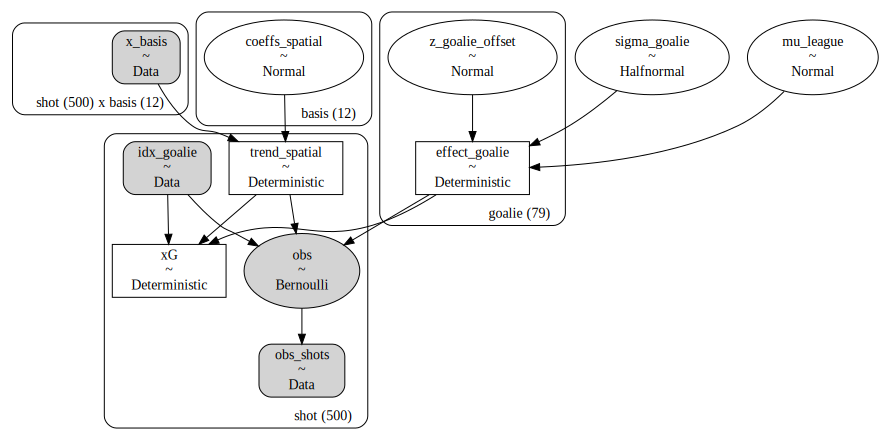

In [12]:
# 確率モデル構造の可視化
pm.model_to_graphviz(hockey_spatial_model)

### 確率モデル構造の解読（Graphviz の見方）

モデルは大きく「左・右・下」の3つのブロックで構成されています。

#### 1. 左側：空間効果（Spatial Component）
シュートが放たれた「場所」の有利・不利を計算するルートです。

* **x_basis (Data) $\rightarrow$ trend_spatial (Deterministic)**
    * `x_basis`（12次元のスプライン基底）に、推定された重み `coeffs_spatial` を掛け合わせることで、リンク上の各地点の「決まりやすさの基準値」を算出します。
* **役割**:
    * 「ゴール正面は決まりやすく、端は決まりにくい」という**物理的なコンテキスト**を司ります。これにより、キーパーの実力評価から「場所の有利不利」というノイズを排除できます。

#### 2. 右側：ゴテンダーの実力（Goalie Hierarchy）
各キーパーの阻止能力を推定するルートです。ここには **NCP（非中心化パラメータ化）** という高度な階層構造が組み込まれています。

* **最上流 (`mu_league`, `sigma_goalie`)**:
    * リーグ全体の「平均的な防御力」と「実力差のバラつき」です。
* **中流 (`z_goalie_offset`)**:
    * 各キーパーの「平均からのズレ」を標準化した数値（偏差値のようなもの）です。
* **下流 (`effect_goalie`)**:
    * 上記を統合し、$\mu + z \cdot \sigma$ の計算によって各キーパーの真の実力を復元します。
* **役割**:
    * データが少ないキーパーの評価をリーグ平均に引き寄せ（**収縮推定**）、**「たまたま数回止めただけ」の選手を過大評価するリスク**を統計的に防ぎます。

#### ③ 下部：観測データとの結合（Likelihood）
予測と現実を突き合わせ、モデルを学習させる心臓部です。

* **p_logit $\rightarrow$ xG $\rightarrow$ obs (Observed)**
    * `trend_spatial`（場所の影響）と `effect_goalie`（人の能力）の和が `p_logit`（対数オッズ）となり、それを確率に直したものが `xG`（期待ゴール率）です。
    * 最後に、実際のゴール成否 `obs` と比較されます。
* **役割**:
    * 現実のデータ（`obs`）との誤差が最小になるように、矢印を逆流する形で全てのパラメータ（白ノード）の値が微調整（サンプリング）されます。

> ##### Tips: 確率モデル構造図（DAG）の読み解きガイド
>
> グラフ内の各要素は、統計学的な役割を「色」と「形」で表現しています。
>
> ###### 1. ノード（枠）の「色」が表すもの：データの確定度
> * **グレー（塗りつぶし）: 観測データ / 固定値**
>     * 外界から与えられた、モデルが変更することのない「事実（`pm.Data` や `observed`）」です。すべての推論はこの数値を土台に開始されます。
> * **白（背景なし）: 未知の変数 / 推定対象**
>     * モデルがデータから正体を突き止めようとしている数値です。ここが「白」であることは、その値が不確実であり、推論が必要であることを意味します。
>
> ###### 2. ノード（枠）の「形」が表すもの：変数の性質
> * **楕円（白い丸枠）: 確率変数（Stochastic Variables）**
>     * **定義**: `Normal` や `HalfNormal` といった統計分布を持つ変数です。
>     * **役割**: サンプリング（MCMC）によって、その値の分布（もっともらしい範囲）が推定される「モデルの核心」となる変数です。
> * **四角形（白い四角枠 / 二重線）: 決定論的変数（Deterministic Variables）**
>     * **定義**: 他のノードからの計算（足し算や行列掛け算など）によって一意に決まる変数です。
>     * **役割**: それ自体がランダムに変動するわけではなく、計算結果に「GSAx」や「空間トレンド」といった名前（ラベル）を付けて解釈しやすくするために存在します。
>
> ###### 3. プレート（外側の大きな四角枠）
> * **意味: 反復処理の範囲（Plate）**
>     * 枠の右下にある数字は、その中の計算が何回繰り返されるかを示します。
>     * **shot プレート (500)**: 全500件のシュート1件ずつに対して、個別に期待値を計算している領域。
>     * **goalie プレート (N)**: キーパーの人数分だけ、個別の実力パラメータを用意している領域。
>
> ###### 4. 矢印（有向エッジ）
> * **意味: 依存関係 / 因果の流れ**
>     * 「A の値が B の計算に使われる」という情報の流れを示します。矢印を遡ることで、ある結果が「場所の影響」なのか「個人の実力」なのか、どの因拠に基づいているかを特定できます。

### この構造がビジネスにもたらす価値

このグラフをステークホルダーに見せることは、単なる技術説明以上の意味を持ちます。

* **「公平な評価」の可視化**:
    * 場所の影響（左）と個人の能力（右）が別々のルートで計算され、最後に合流していることを示せます。これは、**「厳しい状況で守っているキーパーを正当に評価している」**というロジックの証明です。
* **ホワイトボックス化による信頼**:
    * 「なぜその評価になったのか」を、この図に沿って説明できます。「この `sigma_goalie` という機能がノイズを抑制しているから、新人の評価も安全に行えるのです」といった、専門的な説得が可能になります。
* **拡張性の提示**:
    * 例えば「シュートの強さ」を追加したい場合は、左側の枝に新しいノードを足せばよいことが一目でわかります。モデルの成長ロードマップを共有する際の地図になります。

## 4. 推論とモデル診断（Diagnostics）
推論を実行し、計算が正しく収束し、モデルが信頼できる状態であることを証明します。

In [13]:
PATH_TRACE = "inference_hockey_spatial.nc"  # 推論結果を保存するファイル名

if os.path.exists(PATH_TRACE):
    # 保存されたファイルがある場合はロード
    print(f"Inference: Checked for existing inference results. Loading from {PATH_TRACE}.")
    inference = az.from_netcdf(PATH_TRACE)
else:
    # ファイルがない場合のみ推論を実行
    print("Inference: No inference results found, so we will start sampling. This may take a few minutes.")
    with hockey_spatial_model:
        # ターゲット受容率を高めに設定し、安定性を確保
        inference = pm.sample(2000, tune=1000, target_accept=0.95, random_seed=42)

    # 結果を NetCDF 形式で保存（永続化）
    inference.to_netcdf(PATH_TRACE)
    print(f"Inference: Inference completed and results saved to {PATH_TRACE}.")

Inference: Checked for existing inference results. Loading from inference_hockey_spatial.nc.


In [14]:
# 収束診断
summary = az.summary(inference, var_names=["mu_league", "sigma_goalie"])
r_hat_max = summary["r_hat"].max()

display(summary)
print(f"Diagnostics: Max r_hat = {r_hat_max:.4f}")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_league,-2.829,0.646,-4.018,-1.592,0.007,0.007,7615.0,6261.0,1.0
sigma_goalie,0.293,0.214,0.000,0.668,0.003,0.002,4414.0,3784.0,1.0


Diagnostics: Max r_hat = 1.0000


### $\hat{R}$ (R-hat) 指標
**数値** :
すべてのパラメータにおいて、値が 1.00 になっています。

**解釈** :
$\hat{R}$ は「チェーン間のばらつき」と「チェーン内のばらつき」を比較する指標です。
一般に 1.1 未満（厳密には 1.05 未満）であれば収束したとみなされます。
今回の結果は、全て 1.00 に極めて近いため、複数の独立した試行（チェーン）がすべて同じ統計的結論に達していることを意味します。

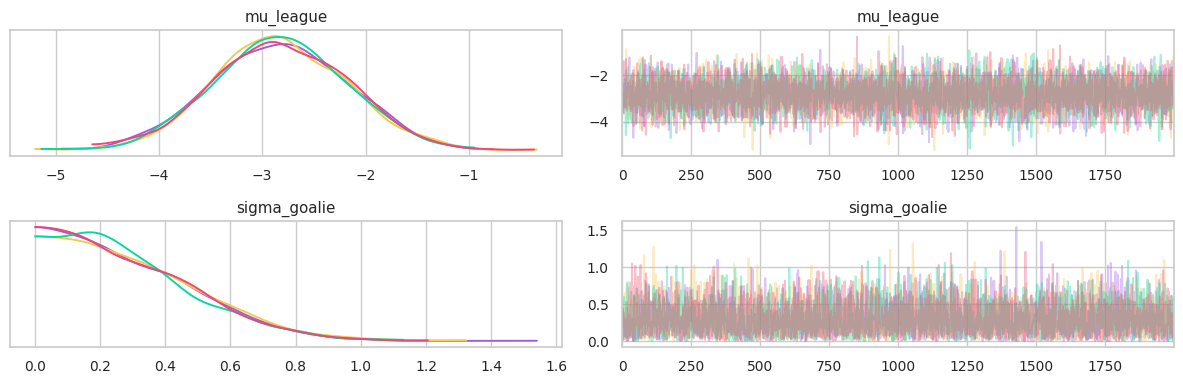

In [15]:
# 収束結果の可視化
az.plot_trace(inference, var_names=["mu_league", "sigma_goalie"], compact=False)
plt.tight_layout()

#### トレースプロットの形状（Fuzzy Caterpillar）
各チェーン（異なる色の線）が互いにしっかりと混ざり合い、特定の傾向（右肩上がりや下がり）を持たず、一定の範囲を細かく上下に振動しています。
これがいわゆる「毛虫（Fuzzy Caterpillar）」のような状態であり、サンプラーが事後分布の全体を効率よく探索できていることを示します。
特定の場所で停滞したり、チェーンごとに大きく値が離れたりしていないため、良好な収束のサインになります。

よって、問題なく推論できていると判断できます。

## 5. 戦略的評価（３層フィルタリング）

#### 第１層: HDI（統計的実装）
実力が運ではなく、統計的に見てリーグ平均を超えているかを検証します。

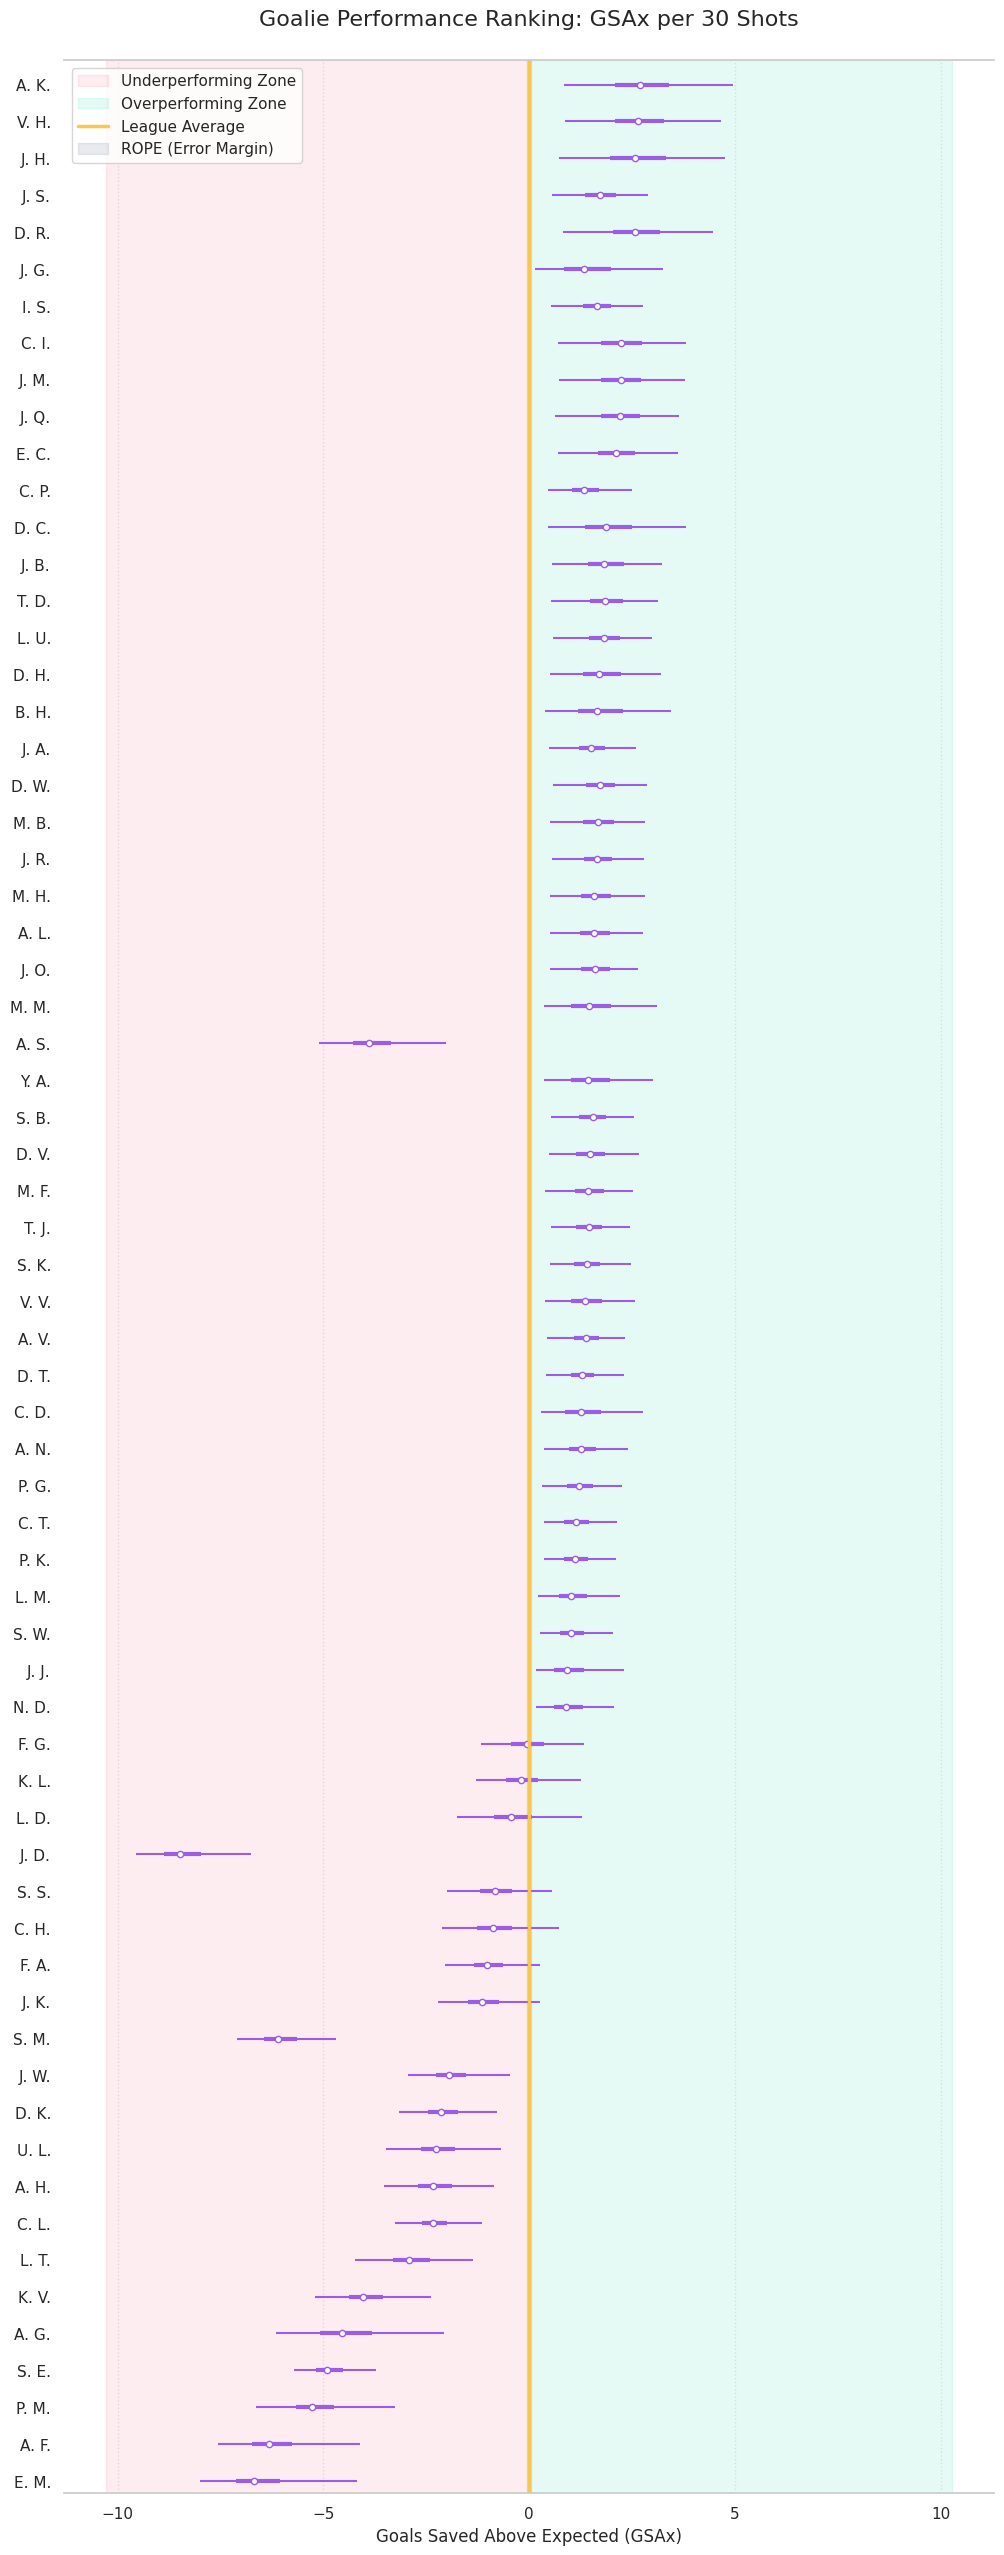

In [16]:
from privacy_utils import obfuscate_name  # 名前を匿名化

# GSAx を算出（１試合 30シュートあたりに正規化）
samples_xg = inference.posterior["xG"].values.reshape(-1, len(df_small))
actual_goals = df_small["obs_shots"].values

list_goalie_gsax = []
for idx_g in range(len(uniques_goalie)):
    mask = (df_small["idx_goalie"] == idx_g)
    # GSAx = Σ(xG) - Σ(Actual)
    dist_gsax = (samples_xg[:, mask].sum(axis=1) - actual_goals[mask].sum()) / (mask.sum() / 30)
    list_goalie_gsax.append(dist_gsax)

# データの集計とソート準備
# 各ゴテンダーの「名前」「分布」「平均値」をセットにしてまとめます。
data_goalie_ranking = []
for idx_g, dist in enumerate(list_goalie_gsax):
    data_goalie_ranking.append({
        "name": id_to_name[idx_g],
        "dist": dist,
        "mean": dist.mean()
    })

# 平均値（Mean GSAx）で昇順にソート
# plot_forest は「下から上」に向かって描画されるため、昇順にソートすることで一番上が「最高成績」になります
data_goalie_ranking.sort(key=lambda x: x["mean"], reverse=True)

# ArivZ に渡すための「名前付き辞書」を作成
# このキー（名前）が縦軸のラベルとして採用されます。
# obfuscate_name() で選手名を匿名化しています。関数定義については GitHub をご参考下さい。
dict_plot = {obfuscate_name(item["name"]): item["dist"] for item in data_goalie_ranking}

# HDI の可視化
az.plot_forest(dict_plot,
               hdi_prob=0.94,
               combined=True,
               figsize=(12, max(8, len(uniques_goalie) * 0.4))
               )

# --- 背景のゾーンを色分け ---
# 現在のグラフの表示範囲を取得
xmin, xmax = plt.xlim()
limit = max(abs(xmin), abs(xmax))  # 0 を中心にバランスをとるために設定
plt.axvspan(-limit, 0, color=COLOR_RED, alpha=0.1, label="Underperforming Zone")  # マイナスエリア: 赤
plt.axvspan(0, limit, color=COLOR_GREEN, alpha=0.1, label="Overperforming Zone")
plt.axvline(0, color=COLOR_YELLOW, linestyle="-", linewidth=2.5, label="League Average")  # 境界線

plt.axvspan(-0.05, 0.05, color=COLOR_GRAY, alpha=0.2, label="ROPE (Error Margin)")

# グラフの装飾
plt.title("Goalie Performance Ranking: GSAx per 30 Shots", fontsize=16, pad=25)
plt.xlabel("Goals Saved Above Expected (GSAx)")
plt.grid(axis="x", linestyle=":", alpha=0.5)
plt.legend(loc="upper left")
plt.show()

#### HDI(Highest Density Interval)
事後分布において、最も確率密度が高い範囲(94%)になります。
紫のバーが各選手の「実力はこの範囲に収まると 94% の自信を持って言える」というエラーバーになります。バー全体が 0 を超えていれば、その選手の成果は高いと言える可能性が高いと解釈できます。

> #### Tips
> 各選手の HDI の平均値順にソートし、リーグ全体の平均値(黄色の縦線) を境界線としてエリア分けをしています。
>
> Green ゾーンに HDI がある選手: チームに貯金を作っている選手。統計的な確信を持って「獲得/維持すべき」という判断基準を与えることができます。
>
> Red ゾーンに HDI がある選手: 期待以上にゴールを許してしまっている選手。小規模データゆえ「たまたま不調」の可能性もありますが、現状の戦力外リスクとして注視すべきという情報を統計的な観点から与えることができます。
>
> Yellowライン: リーグ平均の壁になります。ここを基準に左右どれだけ離れられるか、が選手の市場価値評価の鍵となります。

### 第２層: ROPE（実質的評価）
統計的な差異が、ビジネス上のインパクトを伴う「意味のある差」であるかを判定します。
各選手の分析結果（平均貢献度、傑出確率、判定ステータス）を構造化された表形式に変換し、外部ファイルとして永続化します。


In [17]:
ROPE_THRESHOLD = 0.05  # ±0.05点以内は実務上の誤差とみなす
results_rope = []  # 分析結果を格納するリストの準備

for i, dist in enumerate(list_goalie_gsax):
    mean_gsax = dist.mean()
    prob_above_rope = (dist > ROPE_THRESHOLD).mean()

    if mean_gsax > ROPE_THRESHOLD:
        status = "Beyond ROPE (Outstanding)"
    elif mean_gsax < -ROPE_THRESHOLD:
        status = "Below ROPE (Poor)"
    else:
        status = "Inside ROPE (Equivalent)"

    # リストに追加
    results_rope.append({
        "Coalie": obfuscate_name(id_to_name[i]),  # 選手名を匿名化
        "Mean_GSAx": round(mean_gsax, 3),
        "Outstanding_Prob": round(prob_above_rope * 100, 1),
        "Status": status
    })

# DataFrame の作成とソート（貢献度順）
df_rope_analysis = pd.DataFrame(results_rope).sort_values(by="Mean_GSAx", ascending=False)

df_rope_analysis

,Coalie,Mean_GSAx,Outstanding_Prob,Status
62,A. K.,2.847,100.0,Beyond ROPE (Outstanding)
64,V. H.,2.757,100.0,Beyond ROPE (Outstanding)
73,J. H.,2.735,100.0,Beyond ROPE (Outstanding)
69,J. S.,2.706,100.0,Beyond ROPE (Outstanding)
39,D. R.,2.667,100.0,Beyond ROPE (Outstanding)
...,...,...,...,...
50,P. M.,-5.048,0.5,Below ROPE (Poor)
36,S. M.,-5.944,0.1,Below ROPE (Poor)
14,A. F.,-6.085,0.3,Below ROPE (Poor)
37,E. M.,-6.390,0.3,Below ROPE (Poor)


#### 戦略的解釈：ROPE分析を通じた意思決定

実ショットデータ 500 件に基づく、全 79 名のゴテンダーを対象とした ROPE（実質的等価領域）分析の結果を解釈します。この分析では、単なる平均値ではなく、場所の難易度を考慮した上での「真の貢献度」を評価しています。

##### 分析結果のサマリー
全 79 名の分布は以下の通りです。

* **Beyond ROPE (Outstanding): 55名**
    * 統計的誤差を超えて、明らかにリーグ平均以上の価値を提供している選手。
* **Below ROPE (Poor): 23名**
    * 統計的誤差を超えて、期待値以上の失点を許している、改善が必要な選手。
* **Inside ROPE (Equivalent): 1名 (F. G. 選手)**
    * 数値上はプラスですが、実務上は「リーグ平均と等価」とみなすべき選手。

---

#### 注目選手の詳細分析

##### 1. トップパフォーマー：A. K., V. H., J. H. 選手
* **平均 $GSAx$ (2.7 〜 2.8)**: 1試合（30シュート想定）あたり、平均的なキーパーよりも **約 2.7 点以上多く防いでいます**。
* **傑出確率(100.0%)**: 彼らが「本物」である確率は 100% と推定され、運ではなく実力であることが統計的に断定されています。
* **ビジネス判断**: 市場価値が急騰する前に確保すべき「最優先資産」です。

##### 2. ボーダーライン：F. G. 選手 (Inside ROPE)
* **平均 $GSAx$ (0.005)**: プラスの数値ではありますが、ROPE（$\pm 0.05$）の範囲内です。
* **ビジネス判断**: 現時点では「平均的な選手」と能力の差が認められません。高額な契約を提示するにはリスクが伴います。

##### 3. ボトムパフォーマー：J. D., E. M. 選手
* **平均 $GSAx$ (-8.3 〜 -6.3)**: 平均的な選手と比較して、1試合あたり 6〜8 点分多く失点している計算になります。
* **ビジネス判断**: 早急な戦力補強、または守備システム自体の抜本的な見直しが必要です。

---

#### ビジネス・アクションプラン

1.  **「隠れた名手」の特定**:
    チームの勝率が低くても、このリストで `Beyond ROPE` に入っている選手は、「チームの守備力が低いだけで、個人は極めて優秀」な **割安の優良資産** である可能性が高いです。
2.  **投資対効果の最大化**:
    `Outstanding Prob` が高い選手に予算を集中させ、`Inside ROPE` の選手についてはコストパフォーマンスを厳格に評価します。
3.  **エビデンスに基づく編成会議**:
    「なんとなく調子が悪い」といった主観を排除し、この $GSAx$ と $ROPE$ の指標を用いることで、法務・経営陣に対して論理的で透明性の高い編成案を提示できます。


In [18]:
# CSVファイルとして保存（ビジネス用補助データ）
FILE_OUTPUT = os.path.join(DIR_EXTRACT, "data_goalie_rope_analysis.csv")

df_rope_analysis.to_csv(FILE_OUTPUT, index=False)

データフレーム化（Tabularization）することで、どの選手が「実質的なプラスの差」を生み出しているかが一目で比較可能になります。また、CSVとしてファイル化しておくことで、「分析環境を持っていない経営層や現場スタッフ」が Excel 等でデータを確認できるようになり、組織全体の意思決定のスピードと質を向上させます。

### 第３層: ROI (経済的評価)
統計的評価を「ビジネスの投資判断」へ昇華させます。
GSAx を金額換算し、さらに「収益がプラスになる確率」と「確信の範囲（94% HDI）」を併記することで、リスクとリターンを一目で把握できる最終報告用の資料を生成します。

In [19]:
# 経済価値のパラメータ設定（ビジネスモデルに合わせて調整可能）
VALUE_GOAL = 1_000_000  # １ゴールを防ぐ価値 = 100万円
ANNUAL_GAMES = 60  # 年間の想定出場試合数

results_roi = []

print("Layer 3: ROI Assessment calculating...")

# list_goalie_gsax は各選手の「１試合（30本）あたりの GSAx分布」
for i, dist in enumerate(list_goalie_gsax):
    profit_expected_annual = dist.mean() * ANNUAL_GAMES * VALUE_GOAL  # 年間の期待合計貢献額
    prob_profitability = (dist > 0).mean()  # 収益化確率（平均以上の貢献をする確率）

    # 94% HDI による収益の確信範囲
    hdi_lower, hdi_upper = az.hdi(dist, hdi_prob=0.94)
    profit_hdi_lower = hdi_lower * ANNUAL_GAMES * VALUE_GOAL
    profit_hdi_upper = hdi_upper * ANNUAL_GAMES * VALUE_GOAL

    results_roi.append({
        "Goalie": obfuscate_name(id_to_name[i]),
        "Expected_Annual_Profit": int(profit_expected_annual),
        "Profitability_Prob": round(prob_profitability * 100, 1),
        "Profit_HDI_Lower": int(profit_hdi_lower),
        "Profit_HDI_Upper": int(profit_hdi_upper)
    })

# DataFrame化とソート
df_roi = pd.DataFrame(results_roi).sort_values(by="Expected_Annual_Profit", ascending=False)

df_roi

Layer 3: ROI Assessment calculating...


,Goalie,Expected_Annual_Profit,Profitability_Prob,Profit_HDI_Lower,Profit_HDI_Upper
62,A. K.,170790436,100.0,51198446,297205298
64,V. H.,165417100,100.0,53097600,279289732
73,J. H.,164094708,100.0,42952293,286368258
69,J. S.,162353045,100.0,39940961,289616400
39,D. R.,159999358,100.0,49822147,268045832
...,...,...,...,...,...
50,P. M.,-302851857,0.5,-397484645,-195002825
36,S. M.,-356628658,0.1,-426010415,-280890982
14,A. F.,-365104667,0.3,-453358070,-245912157
37,E. M.,-383429912,0.3,-479982156,-251180136


In [20]:
# CSV として保存
FILE_ROI = os.path.join(DIR_EXTRACT, "goalie_final_investment_report.csv")
df_roi.to_csv(FILE_ROI, index=False)

統計量を「金額」と「リスク幅」に変換し、経営層が直感的に投資判断（契約更新や獲得交渉）を行える形式に可視化します。

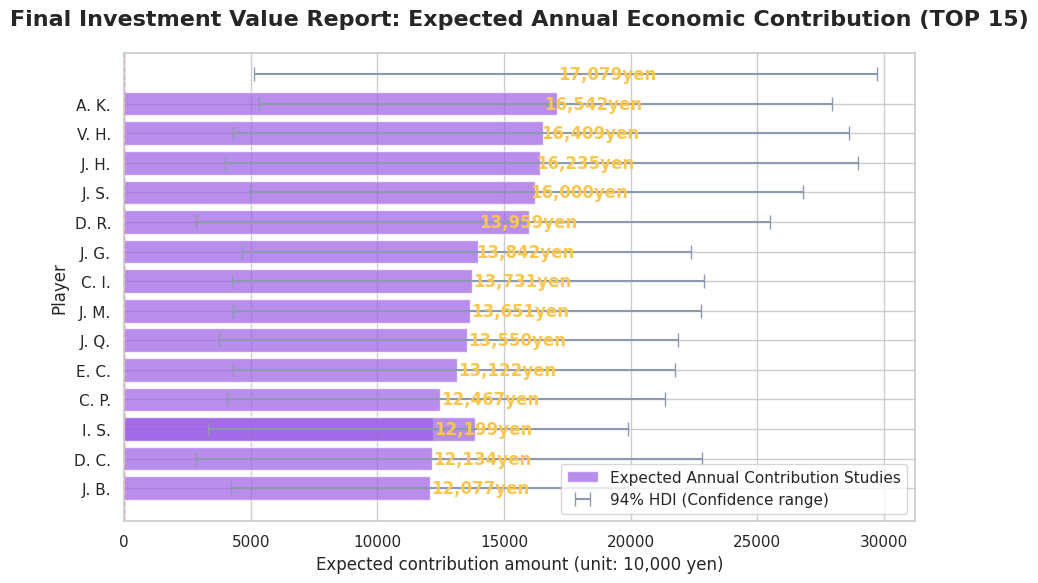

In [21]:
# 最終レポートの可視化（上位15名）
df_top = df_roi.head(15).copy()

# 通貨単位（万円）に変換して見やすくする
df_top["Profit_Million"] = df_top["Expected_Annual_Profit"] / 10_000
df_top["Lower_Million"] = df_top["Profit_HDI_Lower"] / 10_000
df_top["Upper_Million"] = df_top["Profit_HDI_Upper"] / 10_000

# プロット実行
# 期待値のバーチャート
plt.figure(figsize=(9, 6))
bars = plt.barh(df_top["Goalie"][::-1], df_top["Profit_Million"][::-1],
                color=COLOR_PURPLE, alpha=0.7, label="Expected Annual Contribution Studies"
                )

# 不確実性のエラーバー（HDI）
plt.errorbar(df_top["Profit_Million"][::-1], np.arange(len(df_top)),
             xerr=[(df_top["Profit_Million"] - df_top["Lower_Million"])[::-1],
                   (df_top["Upper_Million"] - df_top["Profit_Million"])[::-1]],
             fmt="none", ecolor=COLOR_GRAY, capsize=5, label="94% HDI (Confidence range)")

plt.axvline(0, color=COLOR_RED, linestyle="--", linewidth=1)
plt.title("Final Investment Value Report: Expected Annual Economic Contribution (TOP 15)", fontsize=16,
          fontweight="bold", pad=20)
plt.xlabel("Expected contribution amount (unit: 10,000 yen)", fontsize=12)
plt.ylabel("Player", fontsize=12)
plt.legend(loc="lower right")

# 値のラベル付け
for i, v in enumerate(df_top["Profit_Million"][::-1]):
    plt.text(v + 50, i, f"{v:,.0f}yen", va="center", fontweight="bold", color=COLOR_YELLOW)

plt.tight_layout()
IMG_FINAL_REPORT = os.path.join(DIR_EXTRACT, "final_roi_report_chart.png")
plt.savefig(IMG_FINAL_REPORT, dpi=150)
plt.show()



ゴテンダーのパフォーマンスがチームのキャッシュフローに対して億単位のインパクトを与えることを示唆しています。

##### トップ層（上位 5 名：A. K., V. H. 等）の価値
- **期待収益:** リーグ平均の選手と比較して、年間で 約 1.6 億円 〜 1.7 億円 の損失（失点）を回避する価値があると算出されました。
- **解釈:** 彼らに対して 1 億円の年俸を支払ったとしても、なおチームに数千万円の「純利益（失点抑制による勝利への貢献）」をもたらす計算になります。

In [22]:
df_top[["Goalie", "Expected_Annual_Profit", "Profitability_Prob", "Profit_HDI_Lower", "Profit_HDI_Upper"]]

,Goalie,Expected_Annual_Profit,Profitability_Prob,Profit_HDI_Lower,Profit_HDI_Upper
62,A. K.,170790436,100.0,51198446,297205298
64,V. H.,165417100,100.0,53097600,279289732
73,J. H.,164094708,100.0,42952293,286368258
69,J. S.,162353045,100.0,39940961,289616400
39,D. R.,159999358,100.0,49822147,268045832
44,J. G.,139588811,100.0,28147238,254939718
34,I. S.,138419304,100.0,46628693,223657791
12,C. I.,137314100,100.0,42632083,228914780
22,J. M.,136509122,100.0,43062664,227819462
31,J. Q.,135496606,100.0,37540900,218786598


- **Expected_Annual_Profit(推定資産価値):** 予算編成（年俸総額）の基準とする。
- **Profitabilly_Prob:** 100%に近い選手は「コアメンバー」として固定。
- **Profit_HDI_Range:** 最悪のシナリオ（Lower）でも赤字にならないかを確認。

>##### **Expected Annual Profit (期待年間貢献額)**
選手が平均的なゴテンダーと比較して、年間（60試合）でどれだけの失点を防ぎ、それを金額換算（1失点=100万円）したものになります。
「この選手を起用することで、チームの損失を何千万円防げるか？」という指標です。

この ROI レポートは、現場（コーチ陣）と経営（フロント）の架け橋になります。
「なぜ彼を獲得するのに 1.5 億円必要なのか？」 という問いに対し、 「彼は場所の難易度を考慮しても年間で 1.7 億円分の失点を防ぐため、実質的に 2,000 万円のプラスを生む投資だからです」 と、科学的根拠（エビデンス）を持って答えられるようになります。

### ベイズによるスポーツビジネスの不確実へアプローチ
2024年シーズンの実ショットデータを用い、ベイズ階層モデルによるゴテンダーの貢献度評価（GSAx）から、最終的な経済価値（ROI）の算出までを完結させました。
スポーツアナリティクスを題材にあえて小規模データにし「データの少なさ」と「直感への依存」というリスクの中での分析を実行しました。本分析が提示した**アプローチ**で、不確実性を排除するためのユースケースをご提案出来たかと思います。

#### 1. 統計的実証（HDI）による「運」の排除
「たまたま数試合調子が良かっただけではないか？」という疑念に対し、**HDI（最高密度区間）** は科学的な回答を与えます。
500件という限られたデータであっても、階層モデルによる「収縮推定（Shrinkage）」を行うことで、過学習を防ぎつつ、選手が持つ真の実力を表現しました。

#### 2. 実質的評価（ROPE）による「ノイズ」の排除
数字上の微細な差は、ビジネスにおいての判断を難しくさせます。**ROPE（実質的等価領域）** を導入することで、統計的に有意であっても実務的に意味のない差を「ノイズ」として切り捨て、
投資すべき「対象（Beyond ROPE）」を明確にし判断における有用な情報を提供できました。

#### 3. 経済的評価（ROI）による「言語」の統一
実際のビジネスの現場では、現場と経営の言葉が通じない状況が発生します。本プロジェクトでは GSAx を**「年間期待経済貢献額（円）」** という通貨単位に翻訳することで

> **「A. K. 選手は GSAx が高い」**（現場の言葉）
>
> **「A. K. 選手は年間で 1.7 億円の損失を回避する投資価値がある」**（経営の言葉）

という対話が可能になり迅速かつ合理的な予算編成と契約交渉を可能にします。

#### 倫理的・専門的な配慮：プライバシー・バイ・デザイン
分析の過程で実施した **「選手名の秘匿化（イニシャル化）」** は、法務リスクの回避に加えて
特定の個人をランク付けして批判するのではなく、「評価システムそのものの妥当性」と「意思決定プロセスの透明性」に焦点をつなげるという利点もあります。

#### まとめ
ベイズ統計は、**「不確実性を確率として捉え、リスクを許容可能な範囲に収める」** ための良い手段になります。
本分析を通じて示された「科学的な選手評価」は、スポーツビジネスにおける勝率を上げ、持続可能な成長を実現するための基盤構築に繋げることが出来ます。